# TBP SKIN CANCER DETECTION using SGD / AdaBoost / CatBoost / XGBoost / LGBM

## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.svm import SVC

2024-07-27 21:33:42.065877: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 21:33:42.065980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 21:33:42.171664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
root_dir = '/kaggle/input'

for item in os.listdir(root_dir):
    item_path = os.path.join(root_dir, item)
    if os.path.isdir(item_path):
        print(f"Folder: {item}")
        for filename in os.listdir(item_path):
            file_path = os.path.join(item_path, filename)
            if os.path.isfile(file_path):
                print(file_path)
    elif os.path.isfile(item_path):
        print(item_path)
        
!ls /kaggle/input/isic-2024-challenge

Folder: isic-2024-challenge
/kaggle/input/isic-2024-challenge/sample_submission.csv
/kaggle/input/isic-2024-challenge/train-metadata.csv
/kaggle/input/isic-2024-challenge/test-metadata.csv
/kaggle/input/isic-2024-challenge/test-image.hdf5
/kaggle/input/isic-2024-challenge/train-image.hdf5


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


sample_submission.csv  test-metadata.csv  train-image.hdf5
test-image.hdf5        train-image	  train-metadata.csv


## Basic Data Exploration

In [3]:
df = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv', low_memory=False)
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [4]:
positive_eg = df[df['target'] == 1]
negative_eg = df[df['target'] == 0]

final_test_df = pd.concat([positive_eg.copy()[:50], negative_eg.copy()[:50]]).reset_index().drop(columns = ['index'])


positive_eg = positive_eg.copy()[51:]
negative_eg = negative_eg.copy()[51:].sample(800)

#negative_eg = negative_eg.copy()[51:]

df = pd.concat([positive_eg, negative_eg]).reset_index().drop(columns = ['index'])

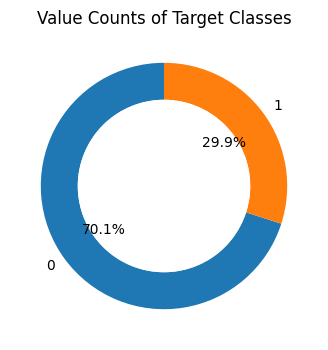

In [5]:
dist = df.target.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist.values, labels=dist.index.astype(str), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Value Counts of Target Classes')
plt.show()

In [6]:
df_test = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv', low_memory=False)
df_test

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


## Preprocessing Pipeline

In [7]:
df['tbp_lv_location_simple'] = df['tbp_lv_location_simple'].replace('Unknown', np.nan)

In [8]:
columns_to_drop = [
    'patient_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 
    'mel_mitotic_index', 'mel_thick_mm', 'tbp_tile_type','lesion_id', 'iddx_full', 
    'iddx_1', 'attribution', 'copyright_license', 'image_type', 'isic_id','tbp_lv_dnn_lesion_confidence'
]

num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 
    'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 
    'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 
    'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 
    'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 
    'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 
    'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 
    'tbp_lv_symm_2axis', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'
]

cat_cols = [
    'sex', 'anatom_site_general', 
    'tbp_lv_location', 'tbp_lv_location_simple', 
    'tbp_lv_symm_2axis_angle'
]

df.drop(columns=columns_to_drop, inplace=True)

In [9]:
target = list(df.target)

In [10]:


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=20):
        self.k = k
        self.selector = None

    def fit(self, X, y):
        self.selector = SelectKBest(score_func=f_classif, k=self.k)
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        return X[:, self.selector.get_support(indices=True)]

    def get_feature_names_out(self, feature_names):
        return [feature_names[i] for i in self.selector.get_support(indices=True)]

pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), cat_cols)
        ]
    )),
    ('feature_selector', FeatureSelector(k=100))
])

X = df[num_cols + cat_cols]
y = df['target']

X_reduced = pipeline.fit_transform(X, y)

preprocessor = pipeline.named_steps['preprocessor']
feature_selector = pipeline.named_steps['feature_selector']

feature_names = preprocessor.get_feature_names_out()

selected_feature_names = feature_selector.get_feature_names_out(feature_names)

X_reduced_df = pd.DataFrame(X_reduced, columns=selected_feature_names)
X_reduced_df['target'] = y.values

X_reduced_df.head()

,num__age_approx,num__clin_size_long_diam_mm,num__tbp_lv_A,num__tbp_lv_Aext,num__tbp_lv_B,num__tbp_lv_Bext,num__tbp_lv_C,num__tbp_lv_Cext,num__tbp_lv_H,num__tbp_lv_Hext,...,cat__tbp_lv_symm_2axis_angle_135,cat__tbp_lv_symm_2axis_angle_140,cat__tbp_lv_symm_2axis_angle_145,cat__tbp_lv_symm_2axis_angle_150,cat__tbp_lv_symm_2axis_angle_155,cat__tbp_lv_symm_2axis_angle_160,cat__tbp_lv_symm_2axis_angle_165,cat__tbp_lv_symm_2axis_angle_170,cat__tbp_lv_symm_2axis_angle_175,target
0,1.608562,3.304716,-0.146960,0.057869,0.741393,0.460534,0.465017,0.347192,0.684286,0.199780,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,-0.308246,2.133627,0.484081,-0.674317,-0.327548,0.077557,-0.039292,-0.264858,-0.659930,0.710843,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.841839,4.283703,0.943566,1.185055,-1.009800,-0.934203,-0.229635,-0.122141,-1.670287,-1.746553,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.225200,-0.891996,0.924092,1.222338,0.289339,0.017499,0.628753,0.572211,-0.487955,-1.077123,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,0.000000,-1.235565,0.512271,1.281383,-0.829114,-0.374556,-0.365912,0.322924,-1.155236,-1.396874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
df = X_reduced_df


## Augementing Data using SMOTE


In [12]:
X = df.drop(columns=['target'])
y = df['target']

rus = SVMSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=10)

X_resampled, y_resampled = rus.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['target'] = y_resampled
df_resampled.drop_duplicates(inplace = True)

/tmp/ipykernel_24/4194984026.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['target'] = y_resampled


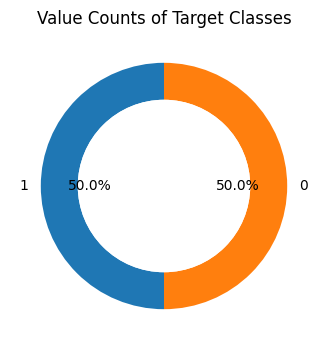

In [13]:
dist = df_resampled.target.value_counts()

plt.figure(figsize=(4, 4))
plt.pie(dist.values, labels=dist.index.astype(str), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Value Counts of Target Classes')
plt.show()

In [14]:
df = df_resampled
df.shape

(1600, 101)

## Applying Models

In [15]:
pAUCscores = []
confMatrix = []
cfReport = []

In [16]:
class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if not pd.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    v_gt = abs(np.asarray(solution.values) - 1)
    v_pred = -1.0 * np.asarray(submission.values)

    max_fpr = abs(1 - min_tpr)

    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc


### Applying LightGBM

In [17]:
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

y_scores = lgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_scores > 0.5).astype(int)

solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_test})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_test, y_pred))
cfReport.append(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 645, number of negative: 635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9258
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503906 -> initscore=0.015625
[LightGBM] [Info] Start training from score 0.015625


### Applying XGBoost

In [18]:
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_scores = xgb_model.predict_proba(X_test)[:, 1]
y_true = y_test
y_pred = (y_scores > 0.5).astype(int)

solution = pd.DataFrame({'row_id': range(len(y_test)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_test, y_pred))
cfReport.append(classification_report(y_test, y_pred))

### Apply CATBoost

In [19]:
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

catboost_model = CatBoostClassifier(verbose=0)
catboost_model.fit(X_train, y_train)

y_pred = catboost_model.predict(X_test)
y_true = y_test
y_scores = catboost_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))

### Applying ADABoost

In [20]:
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(X_train, y_train)

y_pred = adaboost_model.predict(X_test)
y_scores = adaboost_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
conf_matrix = confusion_matrix(y_test, y_pred)
cf_report = classification_report(y_test, y_pred)

pAUCscores.append(pAUC)
confMatrix.append(conf_matrix)
cfReport.append(cf_report)

### Applying GBR

In [21]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train, y_train)

y_pred = gbm_model.predict(X_test)
y_true = y_test

y_scores = gbm_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))

### Applying SVM

In [22]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
y_true = y_test

y_scores = svm_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))

### Applying RF

In [23]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
y_true = y_test

y_scores = random_forest_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))

### Applying BRF

In [24]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

brf_model = BalancedRandomForestClassifier(random_state=42)
brf_model.fit(X_train, y_train)

y_pred = brf_model.predict(X_test)
y_true = y_test

y_scores = brf_model.predict_proba(X_test)[:, 1]

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))

/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


### Using Deep Neural Networks

In [25]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.05)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.05)),
    Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.05))
])

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=64, verbose=2)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

y_scores = model.predict(X_test).flatten()

solution = pd.DataFrame({'row_id': range(len(y_true)), 'target': y_true})
submission = pd.DataFrame({'row_id': range(len(y_scores)), 'prediction': y_scores})

pAUC = score(solution, submission, 'row_id', min_tpr=0.80)

pAUCscores.append(pAUC)
confMatrix.append(confusion_matrix(y_true, y_pred))
cfReport.append(classification_report(y_true, y_pred))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


I0000 00:00:1722116063.530804     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 - 5s - 325ms/step - accuracy: 0.6025 - loss: 9.4940 - val_accuracy: 0.7812 - val_loss: 8.1807
Epoch 2/20
16/16 - 0s - 4ms/step - accuracy: 0.7373 - loss: 7.2867 - val_accuracy: 0.8281 - val_loss: 6.2428
Epoch 3/20
16/16 - 0s - 4ms/step - accuracy: 0.7852 - loss: 5.5586 - val_accuracy: 0.8398 - val_loss: 4.7450
Epoch 4/20
16/16 - 0s - 4ms/step - accuracy: 0.7910 - loss: 4.2320 - val_accuracy: 0.8438 - val_loss: 3.6103
Epoch 5/20
16/16 - 0s - 4ms/step - accuracy: 0.8027 - loss: 3.2424 - val_accuracy: 0.8281 - val_loss: 2.7608
Epoch 6/20
16/16 - 0s - 4ms/step - accuracy: 0.8135 - loss: 2.4948 - val_accuracy: 0.8398 - val_loss: 2.1319
Epoch 7/20
16/16 - 0s - 4ms/step - accuracy: 0.8164 - loss: 1.9484 - val_accuracy: 0.8555 - val_loss: 1.6704
Epoch 8/20
16/16 - 0s - 4ms/step - accuracy: 0.8145 - loss: 1.5554 - val_accuracy: 0.8633 - val_loss: 1.3365
Epoch 9/20
16/16 - 0s - 4ms/step - accuracy: 0.8262 - loss: 1.2630 - val_accuracy: 0.8633 - val_loss: 1.0973
Epoch 10/20
16/16 - 0s - 4ms

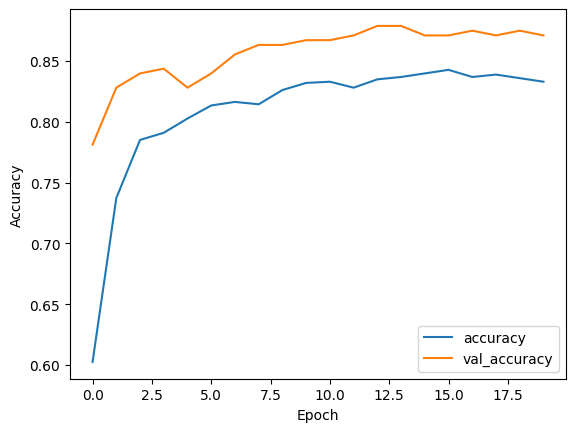

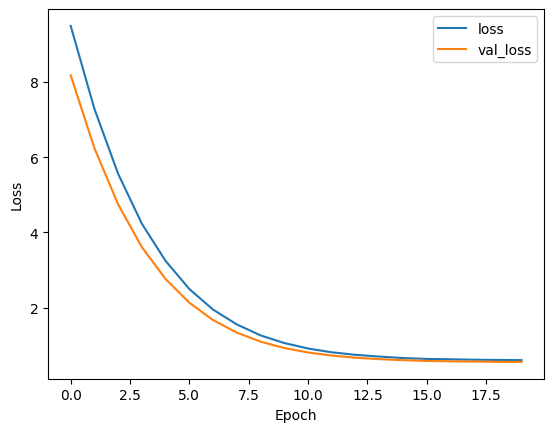

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## Overall Metrics

In [27]:
models = ['LGBM', 'XGB', 'CAT', 'ADB', 'GBM', 'SVM', 'RF', 'BRF', 'DNN']

for ps, conf, cf, md in zip(pAUCscores, confMatrix, cfReport, models):
    print('----------------------------------')
    print('Metrics for', md)
    print('pAUC Score:\n', ps)
    print('Confusion Matrix:\n', conf)
    print('Other Metrics Report:\n', cf)

----------------------------------
Metrics for LGBM
pAUC Score:
 0.17880742913000974
Confusion Matrix:
 [[147  18]
 [  8 147]]
Other Metrics Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       165
           1       0.89      0.95      0.92       155

    accuracy                           0.92       320
   macro avg       0.92      0.92      0.92       320
weighted avg       0.92      0.92      0.92       320

----------------------------------
Metrics for XGB
pAUC Score:
 0.17912023460410553
Confusion Matrix:
 [[147  18]
 [  6 149]]
Other Metrics Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       165
           1       0.89      0.96      0.93       155

    accuracy                           0.93       320
   macro avg       0.93      0.93      0.92       320
weighted avg       0.93      0.93      0.92       320

----------------------------------
Metrics for 

## Evaluating Score pAUC (without submission)

In [28]:
def predict(test_data: pd.DataFrame, pipeline: Pipeline, model_) -> pd.DataFrame:
    isic_id = test_data['isic_id']
    
    test_data['tbp_lv_location_simple'] = test_data['tbp_lv_location_simple'].replace('Unknown', np.nan)

    test_data_processed = pipeline.transform(test_data)
    
    feature_names = pipeline.named_steps['feature_selector'].get_feature_names_out(pipeline.named_steps['preprocessor'].get_feature_names_out())
    
    test_data_processed_df = pd.DataFrame(test_data_processed, columns=feature_names)
    try:
        test_predictions = model_.predict_proba(test_data_processed_df)[:, 1]
    except:
        test_predictions = model_.predict(test_data_processed_df).flatten()
    
    predictions_df = pd.DataFrame({'isic_id': isic_id, 'target': test_predictions})
    
    return predictions_df

X = final_test_df.drop(columns = ['target'])
y = final_test_df['target']

mdls = [lgb_model, xgb_model, catboost_model, adaboost_model, gbm_model, svm_model, random_forest_model, brf_model, model]
mdls_name = ['lgb_model','xgb_model', 'catboost_model', 'adaboost_model', 'gbm_model', 'svm_model', 'random_forest_model', 'brf_model', 'dnn']

best_model = None
best_model_name = None
max_puac = 0
sum_puac = 0
for m, n in zip(mdls, mdls_name):
    print(n)
    predicted_df = predict(X, pipeline, m)
    
    predicted_df['actual_target'] = y
    solution = pd.DataFrame({'row_id': range(len(predicted_df['actual_target'])), 'target': predicted_df['actual_target']})
    submission = pd.DataFrame({'row_id': range(len(predicted_df['target'])), 'prediction': predicted_df['target']})
    pAUC = score(solution, submission, 'row_id', min_tpr=0.80)
    print(pAUC)
    
    
    
    sum_puac += pAUC
    if(pAUC > max_puac):
        max_puac = pAUC
        best_model = m
        best_model_name = n


print(f'Best pAUC Model: {best_model_name}')
print(f'Average pAUC:{sum_puac/len(mdls)}')

lgb_model
0.16439999999999994
xgb_model
0.15359999999999996
catboost_model
0.16519999999999996
adaboost_model
0.13799999999999998
gbm_model
0.16359999999999994
svm_model
0.14559999999999995
random_forest_model
0.16179999999999994
brf_model
0.15959999999999996
dnn
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
0.11799999999999997
Best pAUC Model: catboost_model
Average pAUC:0.15219999999999995


In [29]:
test_data = pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv', low_memory=False)
predicted_df = predict(test_data, pipeline, best_model)
predicted_df.to_csv('submission.csv', index=False)
predicted_df

,isic_id,target
0,ISIC_0015657,0.026350
1,ISIC_0015729,0.007922
2,ISIC_0015740,0.109024


In [30]:
best_model